In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

# مسار الصور وملفات XML
images_path = r"F:\playing\mask\images"
xml_path = r"F:\playing\mask\annotations"
output_path =r"F:\playing\mask\data"

os.makedirs(output_path, exist_ok=True)

for xml_file in os.listdir(xml_path):
    if not xml_file.endswith(".xml"):
        continue
    
    tree = ET.parse(os.path.join(xml_path, xml_file))
    root = tree.getroot()

    filename = root.find("filename").text
    img = Image.open(os.path.join(images_path, filename))

    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = obj.find("bndbox")
        
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # قص الصورة
        cropped = img.crop((xmin, ymin, xmax, ymax))

        # حفظ الصورة المقصوصة
        label_folder = os.path.join(output_path, label)
        os.makedirs(label_folder, exist_ok=True)
        cropped.save(os.path.join(label_folder, filename))

In [10]:
# split data into train and test sets
import random
import shutil

train_folder = os.path.join(output_path, "train")
test_folder = os.path.join(output_path, "test")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Collect all images from label subfolders
all_images = []
for label in os.listdir(output_path):
    label_path = os.path.join(output_path, label)
    if os.path.isdir(label_path) and label not in ["train", "test"]:
        for img in os.listdir(label_path):
            all_images.append((os.path.join(label_path, img), label, img))

random.shuffle(all_images)
split_index = int(len(all_images) * 0.8)  # 80% for training

for i, (src, label, img) in enumerate(all_images):
    dest_folder = train_folder if i < split_index else test_folder
    label_dest = os.path.join(dest_folder, label)
    os.makedirs(label_dest, exist_ok=True)
    shutil.move(src, os.path.join(label_dest, img))

In [17]:
# Import necessary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# know number of image in each class lonly


def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts 

train = r"F:\playing\mask\data\train"
test = r"F:\playing\mask\data\test"   
train_counts = count_images_in_directory(train)
test_counts = count_images_in_directory(test)
print("Training set class counts:", train_counts)
print("Testing set class counts:", test_counts)

Training set class counts: {'mask_weared_incorrect': 79, 'without_mask': 239, 'with_mask': 602}
Testing set class counts: {'mask_weared_incorrect': 18, 'without_mask': 47, 'with_mask': 166}


In [ ]:
# using matplotlib to display pie chart of the training set
import matplotlib.pyplot as plt
# Count the number of images in each class
def count_images_in_directory(counts,kind):
    labels = list(counts.keys())
    counts = list(counts.values())
    # Create a pie chart
    plt.figure(figsize=(3,3))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of Classes in T{kind} Set')
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
    plt.show()

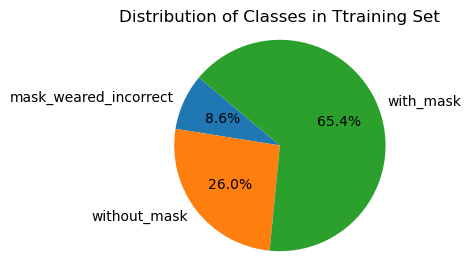

In [18]:
count_images_in_directory(train_counts,"training")

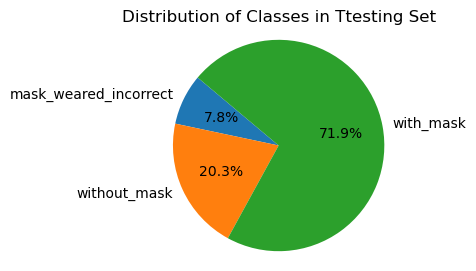

In [19]:
count_images_in_directory(test_counts,"testing")

In [22]:
def size_images_in_directory(directory):
    size = []

    for dir in os.listdir(directory):
        files_path = os.path.join(directory, dir)
        files = os.listdir(files_path)

        for file in files:
            file_path = os.path.join(files_path, file)

            try:
                image = plt.imread(file_path)
                size.append(image.shape)
            except FileNotFoundError:
                print(f"File not found: {file_path}")

    # Display counts of different image sizes
    return pd.Series(size).value_counts()

In [23]:
size_images_in_directory(train)

(20, 17, 4)     5
(15, 14, 4)     5
(6, 6, 4)       5
(22, 20, 4)     5
(14, 12, 4)     5
               ..
(14, 11, 4)     1
(29, 27, 4)     1
(9, 4, 4)       1
(118, 98, 4)    1
(134, 66, 4)    1
Name: count, Length: 705, dtype: int64

In [24]:
size_images_in_directory(test)

(14, 14, 4)      3
(18, 14, 4)      3
(12, 9, 4)       3
(6, 5, 4)        2
(18, 16, 4)      2
                ..
(125, 100, 3)    1
(20, 18, 4)      1
(30, 24, 4)      1
(27, 25, 4)      1
(74, 61, 4)      1
Name: count, Length: 208, dtype: int64

In [27]:

# preprocessing for data
# Rescale pixel values to [0, 1] and apply augmentation to training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for test/validation data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224,224),
    batch_size=15,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(224,224),
    batch_size=15,
    class_mode='categorical'
)


Found 920 images belonging to 3 classes.
Found 231 images belonging to 3 classes.


In [13]:
def show_images(dirct):
    for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in dirct:
            image = X_batch[0]
            label = Y_batch[0]
            # Convert one-hot to integer index
            class_names = list(dirct.class_indices.keys())
            class_index = np.argmax(label)
            class_label = class_names[class_index]
            plt.title(f"Label: {class_label}")
            plt.axis('off')
            plt.imshow(image)
            break

    plt.show()

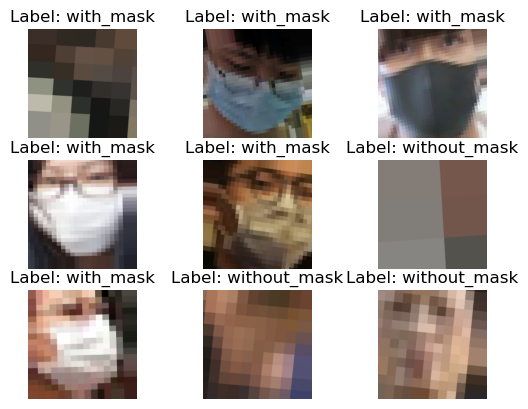

In [28]:
#get labels from count function
show_images(train_generator)

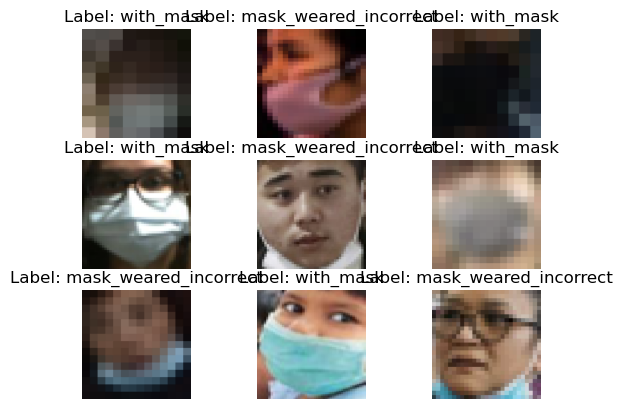

In [29]:
show_images(test_generator)

In [16]:
# visualize training history
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [31]:
# Build CNN model
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # classification
# summary the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      2336      
                                                                 
 dropout_7 (Dropout)         (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)      

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [33]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/10
62/62 [==============================] - 88s 1s/step - loss: 0.7245 - accuracy: 0.7109 - val_loss: 0.6018 - val_accuracy: 0.8442
Epoch 2/10
62/62 [==============================] - 118s 2s/step - loss: 0.5478 - accuracy: 0.7978 - val_loss: 0.4828 - val_accuracy: 0.8701
Epoch 3/10
62/62 [==============================] - 122s 2s/step - loss: 0.4513 - accuracy: 0.8424 - val_loss: 0.4445 - val_accuracy: 0.8788
Epoch 4/10
62/62 [==============================] - 104s 2s/step - loss: 0.4543 - accuracy: 0.8467 - val_loss: 0.3929 - val_accuracy: 0.8701
Epoch 5/10
62/62 [==============================] - 95s 2s/step - loss: 0.4414 - accuracy: 0.8533 - val_loss: 0.4179 - val_accuracy: 0.8831
Epoch 6/10
62/62 [==============================] - 102s 2s/step - loss: 0.4365 - accuracy: 0.8576 - val_loss: 0.3547 - val_accuracy: 0.8788
Epoch 7/10
62/62 [==============================] - 80s 1s/step - loss: 0.4426 - accuracy: 0.8533 - val_loss: 0.3954 - val_accuracy: 0.9048
Epoch 8/10
62/62

In [34]:
prediction=model.predict(test_generator)
from sklearn.metrics import classification_report
# Extracting true labels
true_labels = test_generator.classes

# Convert predicted probabilities to class labels using the class indices
predicted_labels = np.argmax(prediction, axis=1)

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=test_counts.keys())
print(report)

16/16 [==============================] - 9s 328ms/step
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00        18
         without_mask       0.71      0.72      0.71       166
            with_mask       0.21      0.28      0.24        47

             accuracy                           0.57       231
            macro avg       0.30      0.33      0.32       231
         weighted avg       0.55      0.57      0.56       231



d:\ana\envs\Tensorflwo\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ana\envs\Tensorflwo\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\ana\envs\Tensorflwo\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


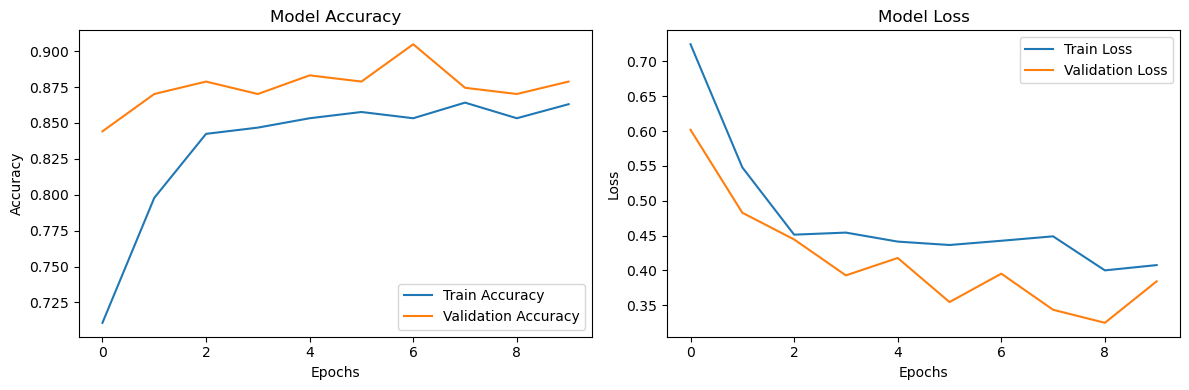

16/16 [==============================] - 8s 527ms/step - loss: 0.3844 - accuracy: 0.8788
Test Loss: 0.38440972566604614, Test Accuracy: 0.8787878751754761


In [35]:
# Plot the training history
plot_training_history(history)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")